In [168]:
import sys
sys.path.append('..')

from calendar import month_abbr

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from canadian_extreme_precip.get_precipitation_quantiles import load_precip_data, get_quantiles

stations_list = [
    'inuvik',
    'sachs harbour',
    'cambridge bay',
    'resolute bay',
    'alert',
    'eureka',
    'hall beach',
    'clyde river',
    'cape dyer',
    'pond inlet',
    ]

# Parameters
year_start = '1960'  # First year to nclude in analysis
year_end = '1995'  # Last year to include in analysis
threshold = 0.01   # Use only daily precipitation greater than this value: exclude zero and trace precipitation days
percentile = 0.95  # Percentile used for analysis

Below are two helper functions.  One for plotting results and one for calculating fraction of P95 days in each month.

In [169]:
def plot_series(df, station=''):
    """Plot time series of daily precipitation for station
    
    :df: pandas DataFrame from load_precip_data
    :station: name of station used as plot title, default is ''
    
    :returns: matplotlib figure and axes instances
    """
    fig, ax = plt.subplots(figsize=(15,7))
    ax.fill_between(df.index, df, step='mid', color='0.5')
    ax.set_ylabel('Total Precipitation (mm)', fontsize=20)
    ax.set_title(station.title(), fontsize=20)
    ax.tick_params('both', labelsize=15)
    return fig, ax


def get_month_counts(station):
    """
    Helper function to calculate fraction of P95 precipitation days that occur in
    each month
    
    :station: name of station to process
    
    :returns: pandas series of fractions by month as percentage
    """
    df = load_precip_data(station)  
    df = df[year_start: year_end]  # Just use data for 1960 to 1995 period  
    p95 = get_quantiles(df, threshold=threshold, quantiles=[percentile]).values[0]  # get 95th percentile
    df95 = df[df > p95]  # Get top 5% of values
    df95_month_counts = df95.groupby(df95.index.month).count() * 100. / len(df95)  # Calculate fraction of 
                                                                                   # values in each month
    return df95_month_counts.round()

## Method

### Load data
To produce Table 3 in the paper on Canadian Extreme Precipitation we use daily total precipitation from the combined station files for each of the nine locations presented in the paper (see Table 1 and Figure 1 in the paper).  We use the period 1960 to 1995 for the analysis for all stations.  This period is the same period used to generate the climatology plots shown in Figure 2.

_If this notebook is being executed and data are available - TBD - each of the five stations can be examined by changing the `station` variable in the cell below_

In [170]:
station = 'cape dyer'
df = load_precip_data(station)
df = df[year_start: year_end]
df

1960-01-01    0.0
1960-01-02    0.0
1960-01-03    0.8
1960-01-04    0.8
1960-01-05    0.0
             ... 
1993-09-26    NaN
1993-09-27    NaN
1993-09-28    NaN
1993-09-29    NaN
1993-09-30    NaN
Name: TOTAL_PRECIPITATION, Length: 12327, dtype: float64

### Get 95th percentile value
The 95th percentile daily total precipitation is found using the `pandas.DataFrame.quantiles` method.  Only non-zero and non-trace values daily total precipitation is used to calculate the percentile by excluding values less than a threshold of 0.01.  This value can be changed by changing the `threshold` parameter in the first cell.

In [171]:
p95 = get_quantiles(df, threshold=threshold, quantiles=[percentile]).values[0]
print(f"95th Percentile {p95} mm")

95th Percentile 18.8 mm


## Find days with Total Precipitation greater than P95th
The daily total precipitation time series is subsetted to include only values greater than the 95th percentiles.  E.g. we only use the top 5% of daily total non-zero and non-trace precipitation.

In [172]:
df95 = df[df > p95]

The time series of precipitation for the analysis period (default is 1960 to 1995) is plotted along with days with precipitation greater than 95th percentile shown by `+`.  The blue horizontal line is the 95th percentile precipitation value.  I refer to these days with precipitation greater than the 95th percetile as P95 days. 

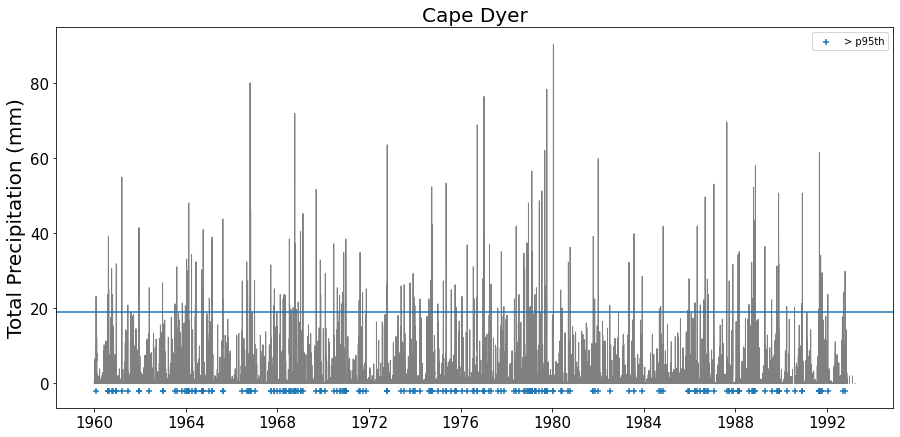

In [173]:
fig, ax = plot_series(df, station)
ax.axhline(p95)
x = df95.index
y = np.ones(len(x)) * -2
ax.scatter(x, y, marker='+', label='> p95th')
ax.legend()

## How many P95 days fall in each month?

In [174]:
print(f'For {station.title()} there are {len(df95)} days with total daily precipitation greater than the 95th percentile ({p95} mm)')

For Cape Dyer there are 224 days with total daily precipitation greater than the 95th percentile (18.8 mm)


To calculate the fraction of P95 days that occur in each month within the period of analysis, the days are grouped by month and counted.  They are divided by the total number of days and multiplied by 100 to get a percentage.

_Months that have no events are assigned NaN.  For analysis of all stations, NaNs are changed to zero._

In [175]:
df95_month_counts = df95.groupby(df95.index.month).count() * 100. / len(df95)
df95_month_counts = df95_month_counts.T.round().astype(int).reindex(np.arange(1,13))
df95_month_counts.index = [month_abbr[im] for im in df95_month_counts.index]
df95_month_counts

Jan    10
Feb     7
Mar     2
Apr     5
May     5
Jun     4
Jul     4
Aug    10
Sep    13
Oct    20
Nov    10
Dec    10
Name: TOTAL_PRECIPITATION, dtype: int64

## Calculate percentage for all stations

To calculate fraction of P95 days in each month, the `get_station_month` function defined in cell 2 is applied to each station combined record.  Results for each station are combined into a `pandas.DataFrame` and some modifications done to produce a clean table.  In particular, percentages are rounded to the nearest integer.  This rounding means that not all rows in the table sum to exactly 100%.  _C'est la vie_.

In [176]:
results = {}
for station in stations_list:
    results[station] = get_month_counts(station)
table02 = pd.DataFrame(results)
table02 = table02.where(table02.notna(), 0.).astype(int)  # Change NaNs to zero
table02.index = [month_abbr[im] for im in table02.index]  # Make month labels abbreviations rather than number
table02.T  # Transpose DataFrame to make nice table

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
inuvik,2,1,1,3,9,12,20,27,10,9,3,3
sachs harbour,1,1,4,8,8,6,12,31,16,7,3,1
cambridge bay,0,0,2,4,8,10,21,29,17,7,2,1
resolute bay,0,0,1,2,3,9,24,37,16,6,2,1
alert,2,0,0,3,6,8,27,20,22,7,2,2
eureka,1,2,2,2,4,11,22,25,17,9,5,1
hall beach,0,1,3,2,4,8,20,30,17,7,3,1
clyde river,1,1,2,4,7,8,12,21,18,13,8,4
cape dyer,10,7,2,5,5,4,4,10,13,20,10,10
pond inlet,2,0,1,2,6,8,25,21,15,12,6,3
